# Setup
- handle imports for requests and pands
- define urls for the old and new ohsome stats api


In [127]:
import requests
import pandas as pd

url_old = r"https://osm-stats-production-api.azurewebsites.net/stats/"
url_new = r"https://demo.contributions-stats.ohsome.org/api/stats/"

pd.set_option('display.float_format','{:.3f}'.format)

hashtags = ["missingmaps","visa","bloomberg"]

## get hashtags based on the definitions of the HOT Partners Repository

In [148]:
import re
import os

def extract_primary_hashtag(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        pattern = r"primary-hashtag:\s*(\w+)"
        match = re.search(pattern, content)
        if match:
            return match.group(1)
        else:
            return None

directory_path = '/home/clemens/Desktop/HeiGit/Projects HIWI/ohsomeNOW/partners/app/_partner/'

# List to store primary hashtag values
primary_hashtags_list = []

for filename in os.listdir(directory_path):
    if filename.endswith('.md'):
        file_path = os.path.join(directory_path, filename)
        primary_hashtag = extract_primary_hashtag(file_path)
        if primary_hashtag:
            primary_hashtags_list.append(primary_hashtag)

print("Primary Hashtags List:", primary_hashtags_list)

hashtags = primary_hashtags_list

print(hashtags)

Primary Hashtags List: ['factset22', 'visamappers', 'salesforce', 'blackrock20', 'aig', 'headingtonschooloxford', 'jlr', 'ftmaps', 'flexvolunteering', 'ourimpact', 'atlassian', 'acthotpilot21', 'awsmapathon', 'hpegives', 'cisco', 'msgivesback', 'hpinspiresgiving', 'accenture', 'aviva', 'msfglobalmapathon2019', 'jpmc', 'amm', 'dhl', 'bloomberg', 'hoganlovells', 'msft']
['factset22', 'visamappers', 'salesforce', 'blackrock20', 'aig', 'headingtonschooloxford', 'jlr', 'ftmaps', 'flexvolunteering', 'ourimpact', 'atlassian', 'acthotpilot21', 'awsmapathon', 'hpegives', 'cisco', 'msgivesback', 'hpinspiresgiving', 'accenture', 'aviva', 'msfglobalmapathon2019', 'jpmc', 'amm', 'dhl', 'bloomberg', 'hoganlovells', 'msft']


## perform GET requests and store in Pandas DataFrame

In [149]:
data = []

for hashtag in hashtags:
    for service, url in zip(["OSM-stats","OHSOME"],[url_old,url_new]):
        req = requests.get(url+hashtag)
        res = req.json()
        res["stat"]="count"+service
        res["hashtag"]
        res["time"]=req.elapsed.total_seconds()
        data.append(res)
    
    
df = pd.DataFrame(data)

df = df.set_index(["hashtag","stat"])

## calculate Diffrences between the two API's

In [150]:
numeric_columns = ['changesets', 'users', 'edits', 'roads', 'buildings']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

ohsome_data = df.xs('countOHSOME', level='stat')

osm_stats_data = df.xs('countOSM-stats', level='stat')

# Calculate percentage change for each statistic
percentage_change = (ohsome_data[numeric_columns] - osm_stats_data[numeric_columns]) / osm_stats_data[numeric_columns] * 100

result_df = pd.DataFrame(percentage_change, columns=['Change %'])
percentage_change["stat"]="diffrenceRelative"
percentage_change = percentage_change.reset_index().set_index(["hashtag","stat"])

absolute_change = (ohsome_data[numeric_columns] - osm_stats_data[numeric_columns])
absolute_change["stat"]="diffrenceAbsolute"
absolute_change = absolute_change.reset_index().set_index(["hashtag","stat"])
df = pd.concat([df, absolute_change, percentage_change], axis=0).sort_index()

In [151]:
display(df)

changesets     users      roads   buildings  \
hashtag       stat                                                             
accenture     countOHSOME        199552.000 18982.000  21404.503 1541802.000   
              countOSM-stats     193723.000 18096.000  49688.216 1554986.000   
              diffrenceAbsolute    5829.000   886.000 -28283.713  -13184.000   
              diffrenceRelative       3.009     4.896    -56.922      -0.848   
acthotpilot21 countOHSOME         10319.000   141.000     25.359   89355.000   
...                                     ...       ...        ...         ...   
salesforce    diffrenceRelative       2.718     2.450    -51.001      -5.000   
visamappers   countOHSOME         12710.000  1010.000      3.568  119154.000   
              countOSM-stats      12104.000   959.000     19.382  135130.000   
              diffrenceAbsolute     606.000    51.000    -15.814  -15976.000   
              diffrenceRelative       5.007     5.318    -81.591     -11.823   

                                      edits                    latest  time  
hashtag       stat                                                           
accenture     countOHSOME       2311050.000      2023-07-20T18:35:08Z 1.131  
              countOSM-stats    1835266.000  2023-07-27T07:12:43.000Z 0.485  
              diffrenceAbsolute  475784.000                       NaN   NaN  
              diffrenceRelative      25.925                       NaN   NaN  
acthotpilot21 countOHSOME        149126.000      2023-04-05T08:32:26Z 0.748  
...                                     ...                       ...   ...  
salesforce    diffrenceRelative      23.485                       NaN   NaN  
visamappers   countOHSOME        188556.000      2023-06-26T23:32:25Z 1.038  
              countOSM-stats     137042.000  2023-06-26T23:32:25.000Z 0.426  
              diffrenceAbsolute   51514.000                       NaN   NaN  
              diffrenceRelative      37.590                       NaN   NaN  

[104 rows x 7 columns]

In [139]:
df.to_csv("./comparisonNew.csv") # store in csv

## Optional Plotting

/tmp/ipykernel_42831/3240242060.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(["hashtag", "stat"]).sum()


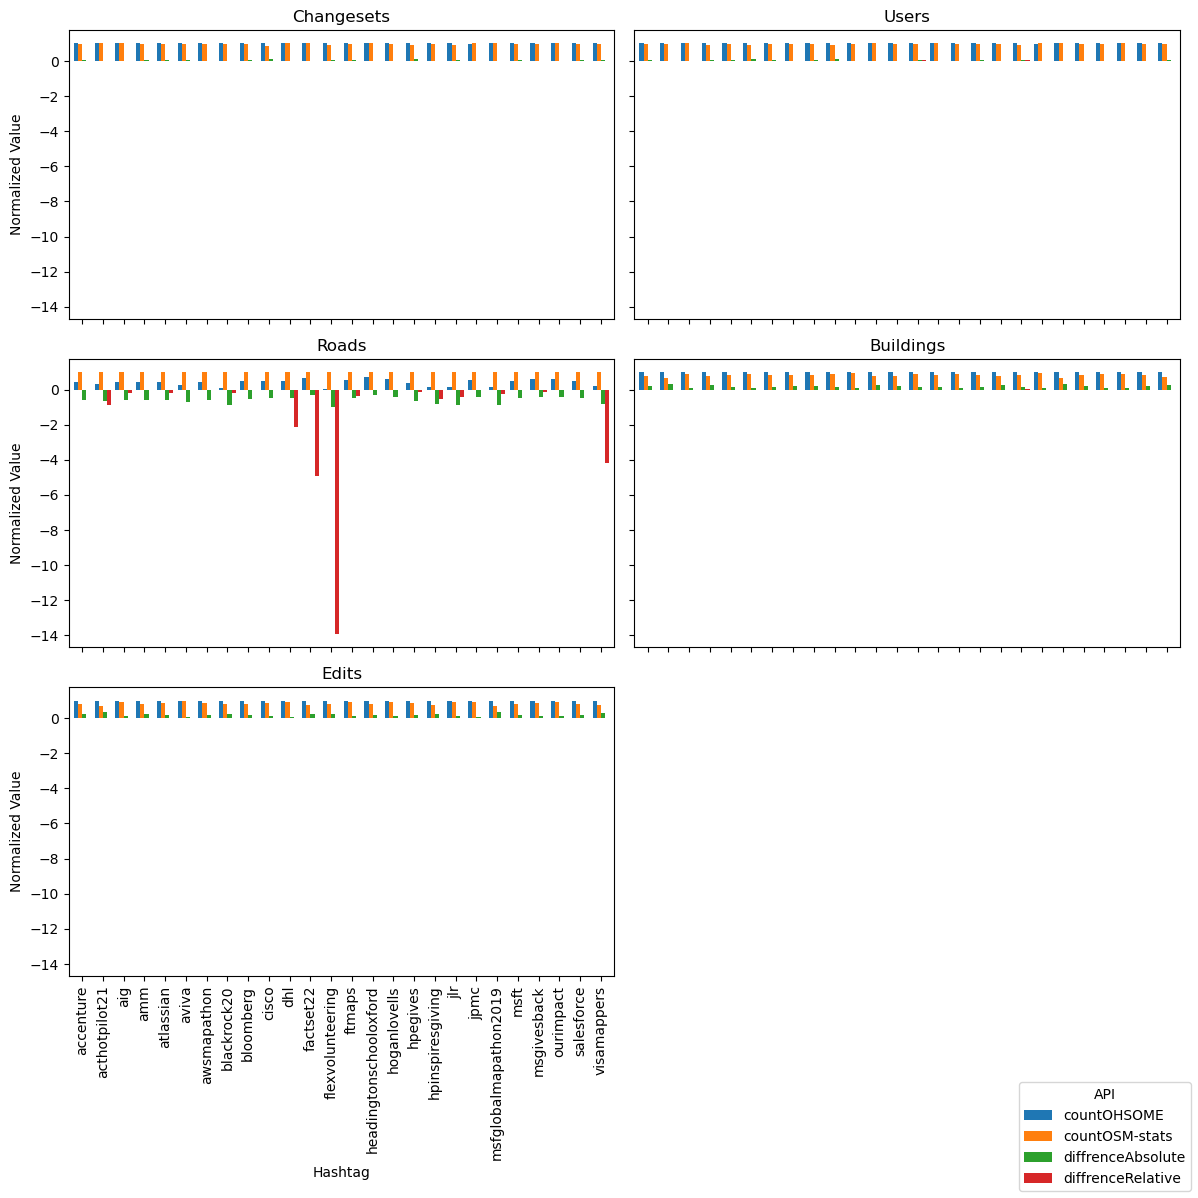

In [100]:
import matplotlib.pyplot as plt

# Grouping the data by the "api" index level and summing the values for each group
grouped_df = df.groupby(["hashtag", "stat"]).sum()

# Create 5 subplots for each statistic
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharex=True, sharey=True)

# List of statistic names for plotting
statistic_names = ["Changesets", "Users", "Roads", "Buildings", "Edits"]

# Iterate over the subplots and plot each statistic
for i, stat in enumerate(["changesets", "users", "roads", "buildings", "edits"]):
    col = i % 2
    row = i // 2
    ax = axs[row, col]

    pivot_table = grouped_df.pivot_table(index="hashtag", columns="stat", values=stat)

    # Normalize the data by the maximum value in each row
    normalized_data = pivot_table.div(pivot_table.max(axis=1), axis=0)

    # Create the bar chart with normalized data, bars next to each other, and different colors
    normalized_data.plot(kind="bar", ax=ax, width=0.8)

    # Add labels and title
    ax.set_title(statistic_names[i])
    ax.set_xlabel("Hashtag")
    ax.set_ylabel("Normalized Value")
    ax.get_legend().remove()

# Use a single legend for all subplots
# Remove the last unused plot (2, 1)
fig.delaxes(axs[2, 1])

# Create an empty legend in the bottom right corner
handles, labels = axs[2, 0].get_legend_handles_labels()
fig.legend(handles, labels, title="API", loc="lower right")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()